In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class AdaptiveImageSegmentation:
    def __init__(self):
        self.image = None
        self.gray = None
        self.binary = None
        self.markers = None

    def load_image(self, image_path):
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError("Không thể đọc ảnh từ đường dẫn đã cho")
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        return self.image

    def segment_watershed(self):
        #Làm mờ ảnh để giảm nhiễu
        blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)

        #Áp dụng Otsu's thresholding
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        #Tạo background
        kernel = np.ones((3,3), np.uint8)
        sure_bg = cv2.dilate(binary, kernel, iterations=3)

        #Tạo foreground
        dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
        dist_transform_norm = np.uint8(255 * dist_transform / dist_transform.max())
        _, sure_fg = cv2.threshold(dist_transform_norm, 0.7 * dist_transform_norm.max(), 255, 0)

        #Tìm unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)

        #Đánh dấu các vùng
        _, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0

        #Áp dụng watershed
        markers = cv2.watershed(self.image, markers)
        self.markers = markers

        return self.create_colored_segmentation()

    def create_colored_segmentation(self): #Hàm làm màu
        n_segments = len(np.unique(self.markers))
        colors = np.random.randint(0, 255, size=(n_segments, 3), dtype=np.uint8)
        colors[0] = [0, 0, 0]
        colors[1] = [255, 255, 255]

        #Tạo ảnh kết quả
        segmented = np.zeros_like(self.image)
        for i in range(n_segments):
            mask = self.markers == (i-1)
            segmented[mask] = colors[i]

        segmented[self.markers == -1] = [0, 0, 255]

        return segmented

    def visualize_results(self, segmented):
        plt.figure(figsize=(15, 10))

        #Ảnh gốc
        plt.subplot(231)
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        plt.title('Ảnh gốc')

        #Ảnh xám
        plt.subplot(232)
        plt.imshow(self.gray, cmap='gray')
        plt.title('Ảnh xám')

        #Ảnh nhị phân
        _, binary = cv2.threshold(self.gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plt.subplot(233)
        plt.imshow(binary, cmap='gray')
        plt.title('Ảnh nhị phân')

        #Distance transform
        dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
        plt.subplot(234)
        plt.imshow(dist_transform, cmap='hot')
        plt.title('Distance Transform')

        #Markers
        markers_display = self.markers.copy()
        markers_display[markers_display == -1] = np.max(markers_display) + 1
        plt.subplot(235)
        plt.imshow(markers_display, cmap='nipy_spectral')
        plt.title('Markers')

        #Kết quả phân vùng
        plt.subplot(236)
        plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
        plt.title('Kết quả phân vùng')

        plt.tight_layout()
        plt.show()

    def result(self):
        foreground = np.zeros_like(self.image)
        foreground[self.markers > 1] = self.image[self.markers > 1]
        background = np.zeros_like(self.image)
        background[self.markers == 1] = self.image[self.markers == 1]

        plt.figure(figsize=(12, 6))
        plt.subplot(121), plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)), plt.title('Foreground (Object)')
        plt.subplot(122), plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB)), plt.title('Background')
        plt.show()

In [9]:
def process_image(image_path): #Hàm thực thi
    segmenter = AdaptiveImageSegmentation()
    segmenter.load_image(image_path)
    segmented = segmenter.segment_watershed()
    segmenter.visualize_results(segmented)
    segmenter.result()
    return segmented

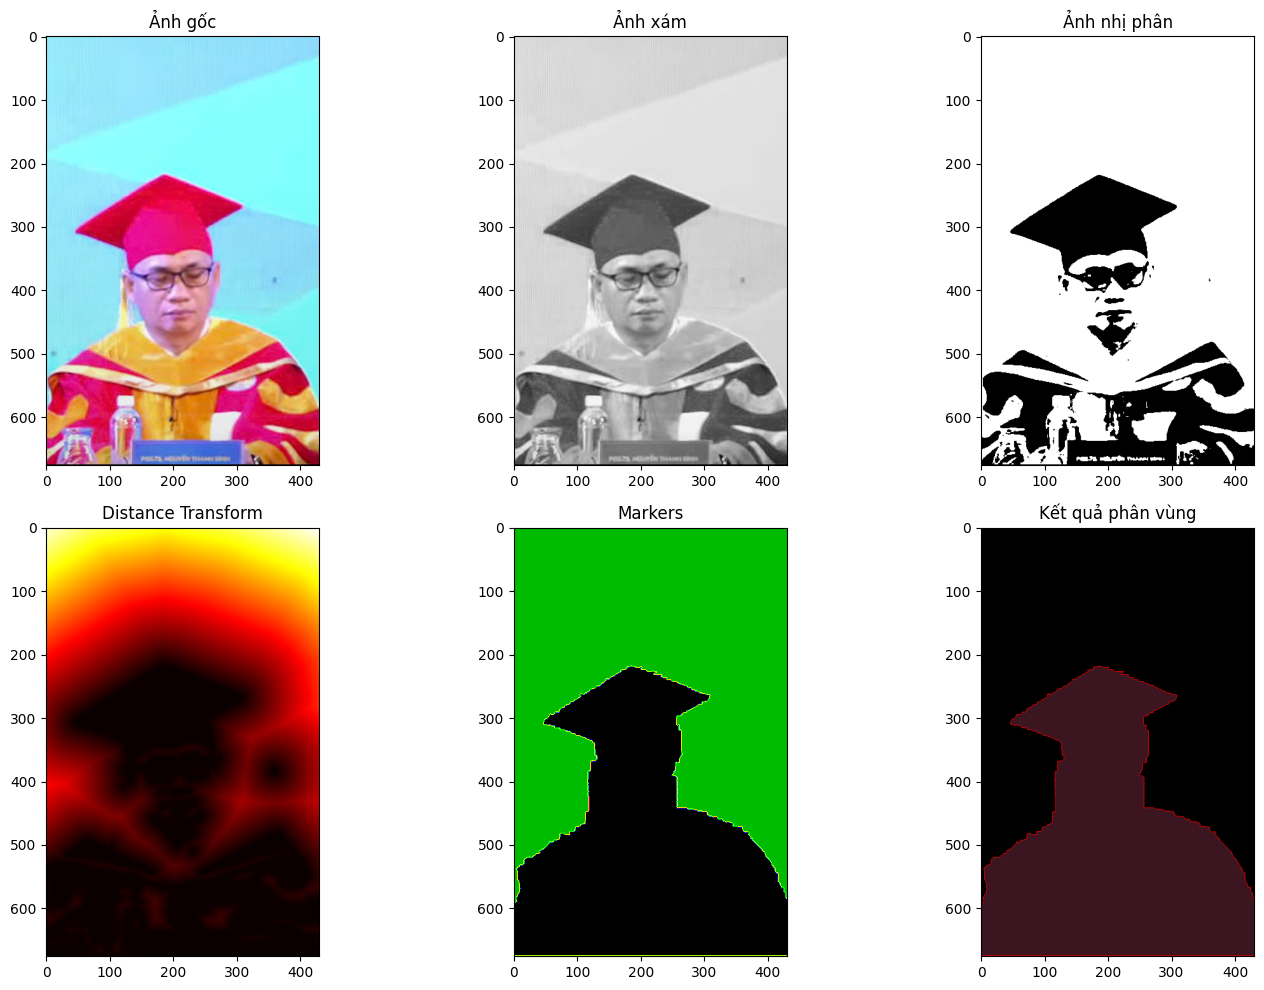

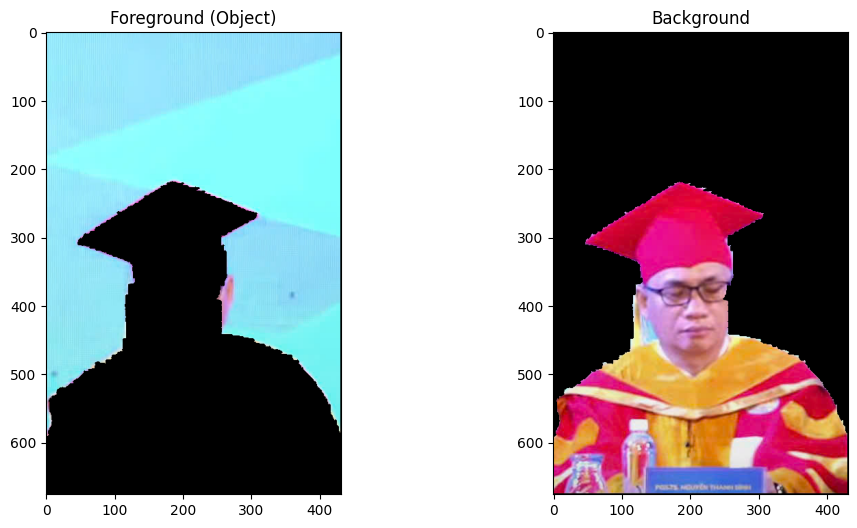

In [10]:
if __name__ == "__main__":
    image_path = './faces_imgs/mrBinh.jpg'
    segmented_image = process_image(image_path)